In [1]:
#written by: Gio

#Import datasets
from utils import mnist_reader
X_train, Y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, Y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
print(X_train.shape, X_train.ndim, X_train.size)
print(Y_train.shape, Y_train.ndim, Y_train.size)

numberOfClass = 10

(60000, 784) 2 47040000
(60000,) 1 60000


In [2]:
#Neural Network Class (MLP)
import numpy as np
import scipy.special
import copy
class myNeuralNet:
    #Initialization of instance variables for a multilayer perceptron
    def __init__(self, nodes, learning_rate):
        # define sigmoid activation function
        self.nodes = nodes
        self.learning_rate = learning_rate
        self.weights = []
        for idx in range(len(self.nodes)-1):
            self.weights.append(np.random.rand(self.nodes[idx+1], self.nodes[idx])-0.5)
        
        self.gd_saved_weights = []
        for idx in range(len(self.nodes)-1):
            self.gd_saved_weights.append(np.zeros((self.nodes[idx+1], self.nodes[idx])))
    
    #Instance method defining activation function used in the multilayer perceptron
    def activation(self, e):
        #sigmoid = 1.0/(1.0+np.exp(-e))
        sigmoid = lambda e: scipy.special.expit(e)
        return sigmoid(e) 
    
    #Instance method for the propagation of the input values to the output values of the neural network
    def predict(self, in_list):
        in_data = np.array(in_list, ndmin=2).T
        #print(in_data.shape)
        current_output = in_data
        for weight in self.weights:
            current_output = self._forward(weight, current_output)
        return current_output
    
    #Instance method that propagates values from one layer to the next
    def _forward(self, weight, layer):
        acti = np.dot(weight, layer)
        return self.activation(acti)
    
    #Instance method that returns the gradient signal for a certain training case 
    def _gradient(self, err, output_out, input_in):
        return np.dot(err*(output_out)*(1-output_out), input_in)
    
    #Instance method that optimizes the neural network using stochastic gradient descent
    def sgd_fit(self, in_list, target_list):
        inputs = np.array(in_list, ndmin = 2).T
        target = np.array(target_list, ndmin = 2).T
        
        outputs = [inputs]
        for weight in self.weights: 
            outputs.append(self._forward(weight, outputs[-1]))
        
        error_out = target-outputs[-1]
        errors = [error_out]
        for idx in range(len(self.weights)-1, 0, -1):
            errors.append(np.dot(self.weights[idx].T, errors[-1]))
        errors.reverse()
        
        for idx in range(len(self.weights)):
            self.weights[idx] += self.learning_rate*self._gradient(errors[idx], outputs[idx+1], outputs[idx].T)
    
    #Instance method that saves the sum of all gradients within a single epoch for batch gradient descent
    def gd_fit(self, in_list, target_list):
        inputs = np.array(in_list, ndmin = 2).T
        target = np.array(target_list, ndmin = 2).T
        
        outputs = [inputs]
        for weight in self.weights: 
            outputs.append(self._forward(weight, outputs[-1]))
        
        error_out = target-outputs[-1]
        errors = [error_out]
        for idx in range(len(self.weights)-1, 0, -1):
            errors.append(np.dot(self.weights[idx].T, errors[-1]))
        errors.reverse()
        
        for idx in range(len(self.gd_saved_weights)):
            self.gd_saved_weights[idx] += self._gradient(errors[idx], outputs[idx+1], outputs[idx].T)
    
    #Instance method that updates the weights with the saved sums of all gradients in batch gradient descent
    def gd_update(self, numberOfSamples):
        for idx in range(len(self.gd_saved_weights)): 
            self.weights[idx] += self.learning_rate*copy.deepcopy(self.gd_saved_weights[idx]/numberOfSamples)
            
        self.gd_saved_weights = []
        for idx in range(len(self.nodes)-1):
            self.gd_saved_weights.append(np.zeros((self.nodes[idx+1], self.nodes[idx])))

In [3]:
#Function that optimizes a neural network w/ stochastic gradient descent
def sgd_train(testNN, X_train, Y_train, epoch, counter): 
    for b in range(epoch):
        print("iteration = ", b)
        for idx in range(len(X_train)):
            y = X_train[idx]
            x = np.full(numberOfClass, 0.01)
            x[int(Y_train[idx])] = 0.99
            placeholder = np.array(y, dtype=float)
            placeholder = placeholder/255.0 * 0.99 + 0.01
            testNN.sgd_fit(placeholder, x)
        if((b+1)%counter == 0):
            training_percentage = findPercentage(X_train, Y_train)
            test_percentage = findPercentage(X_test, Y_test)
            fout.write("%d, %.2f, %.2f\n" %(b+1, training_percentage, test_percentage))
    print("== done ==")

In [4]:
#Function that optimizes a neural network w/ batch gradient descent
def gd_train(testNN, X_train, Y_train, epoch, counter):
    for b in range(epoch):
        print("iteration = ", b)
        for image, answer in zip(X_train, Y_train):
            y = image
            x = np.full(numberOfClass, 0.01)
            x[answer] = 0.99
            placeholder = np.array(y, dtype=float)
            placeholder = placeholder/255.0 * 0.99 + 0.01
            testNN.gd_fit(placeholder, x)
        testNN.gd_update(len(Y_train))
        if((b+1)%counter == 0):
            training_percentage = findPercentage(X_train, Y_train)
            test_percentage = findPercentage(X_test, Y_test)
            fout.write("%d, %.2f, %.2f\n" %(b+1, training_percentage, test_percentage))
    print("== done ==")

In [5]:
#Function that optimizes the neural network w/ mini batch gradient descent
def mini_batch_train(testNN, X_train, Y_train, epoch, batch_size, counter):
    #MNIST is shuffled.
    for b in range(epoch):
        print("iteration = ", b)
        batch_counter = 0
        for image, answer in zip(X_train, Y_train):
            batch_counter = batch_counter + 1
            y = image
            x = np.full(numberOfClass, 0.01)
            x[answer] = 0.99
            placeholder = np.array(y, dtype=float)
            placeholder = placeholder/255.0 * 0.99 + 0.01
            testNN.gd_fit(placeholder, x)
            if(batch_counter == batch_size):
                testNN.gd_update(batch_counter)
                batch_counter = 0
        if batch_counter != 0:
            testNN.gd_update(batch_counter)
        if((b+1)%counter == 0):
            training_percentage = findPercentage(X_train, Y_train)
            test_percentage = findPercentage(X_test, Y_test)
            fout.write("%d, %.2f, %.2f\n" %(b+1, training_percentage, test_percentage))
    print("== done ==")

In [6]:
#mini-batch with small changes (not important)
def dy_mini_batch_train(testNN, X_train, Y_train, epoch, counter):
    #MNIST is shuffled.
    #mini_batch is dynamic in each epoch
    batch_size = 1
    for b in range(epoch):
        print("iteration = ", b)
        batch_counter = 0
        for image, answer in zip(X_train, Y_train):
            batch_counter = batch_counter + 1
            y = image
            x = np.full(numberOfClass, 0.01)
            x[answer] = 0.99
            placeholder = np.array(y, dtype=float)
            placeholder = placeholder/255.0 * 0.99 + 0.01
            testNN.gd_fit(placeholder, x)
            if(batch_counter == batch_size):
                testNN.gd_update(batch_counter)
                batch_counter = 0
                batch_size = batch_size*2
        if batch_counter != 0:
            testNN.gd_update(batch_counter)
        if((b+1)%counter == 0):
            training_percentage = findPercentage(X_train, Y_train)
            test_percentage = findPercentage(X_test, Y_test)
            fout.write("%d, %.2f, %.2f\n" %(b+1, training_percentage, test_percentage))
    print("== done ==")

In [7]:
#mini-batch with small changes (not important)
def dy_mini_batch_train_V2(testNN, X_train, Y_train, epoch, counter):
    #MNIST is shuffled.
    #mini_batch is dynamic during iteration
    batch_size = 1
    for b in range(epoch):
        print("iteration = ", b)
        batch_counter = 0
        for image, answer in zip(X_train, Y_train):
            batch_counter = batch_counter + 1
            y = image
            x = np.full(numberOfClass, 0.01)
            x[answer] = 0.99
            placeholder = np.array(y, dtype=float)
            placeholder = placeholder/255.0 * 0.99 + 0.01
            testNN.gd_fit(placeholder, x)
            if(batch_counter == batch_size):
                testNN.gd_update(batch_counter)
                batch_counter = 0
        batch_size = batch_size*2
        if batch_counter != 0:
            testNN.gd_update(batch_counter)
        if((b+1)%counter == 0):
            training_percentage = findPercentage(X_train, Y_train)
            test_percentage = findPercentage(X_test, Y_test)
            fout.write("%d, %.2f, %.2f\n" %(b+1, training_percentage, test_percentage))
    print("== done ==")

In [8]:
def sigmoid_func(lower, upper, x_val):
    sigmoid = (upper-lower)*1.0/(1.0+np.exp(-x_val))+lower
    return sigmoid

In [9]:
#Function used to derive accuracy of the neural network using the test cases
def findPercentage(X_test, Y_test):
    denominator = 0
    numerator = 0
    for y, ans in zip(X_test, Y_test):
        target = int(ans)
        placeholder = np.array(y, dtype=float)
        placeholder = placeholder/255.0 * 0.99 + 0.01
        finalPrediction = testNN.predict(placeholder)
        save = np.argmax(finalPrediction)

        if(save == target):
            numerator+=1
        else:
            pass
            #print("index: ", idx)
            #print("result: ", save)
            #print("target: ", target)

    success_rate = numerator/len(X_test)
    return success_rate
    print("success_rate", success_rate)

In [10]:
#record performance on a separate file called "result.txt"
fout = open('result.txt', 'w')
fout.write("epoch, rate of training, rate of test\n")
learningRate = [0.01]
for lrate in learningRate:
    #reset random values to arbitrary
    np.random.seed(100)
    testNN = myNeuralNet([784, 256, 128, 100, 10], lrate) #0.3
    print("learning rate", lrate)
    
    #sgd_train(testNN, X_train, Y_train, epoch, counter)
    
    #initial training set
    sgd_train(testNN, X_train[:10000], Y_train[:10000], 5, 1)
    
    #data stream 
    sgd_train(testNN, X_train[10000:], Y_train[10000:], 1, 1)
    
    training_percentage = findPercentage(X_train, Y_train)
    test_percentage = findPercentage(X_test, Y_test)
    print("training percentage", training_percentage, "test percentage", test_percentage)
fout.close()

learning rate 0.01
iteration =  0
iteration =  1
iteration =  2
iteration =  3
iteration =  4
== done ==
iteration =  0
== done ==
training percentage 0.8024666666666667 test percentage 0.7893


0


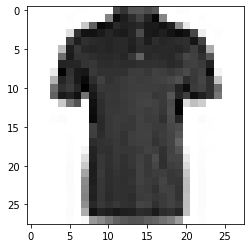

In [31]:
#reference:
#Label / Description
#0 => T-shirt/top
#1 => Trouser
#2 => Pullover
#3 => Dress
#4 => Coat
#5 => Sandal
#6 => Shirt
#7 => Sneaker
#8 => Bag
#9 => Ankle boot

test = 10027
print(Y_train[test])
plt.imshow(X_train[test].reshape(28,28), cmap='Greys', interpolation='None')